In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Unit conversion

References:
- https://developer.valvesoftware.com/wiki/Counter-Strike:_Global_Offensive_Mapper%27s_Reference
- https://developer.valvesoftware.com/wiki/Dimensions
- https://old.reddit.com/r/GlobalOffensive/comments/9v3xjy/csgo_units/
- 3kliksphilip: Battleroyale Map Sizes Compared - CS:GO's Blacksite | https://www.youtube.com/watch?v=bcRZclTd5J8
- Constraint that the player model should cover at most 4x4 px area
- Constraint that the player sees up to 108 px ahead, which must roughly cover the expected accurate range (about 20m)

In [2]:
def units_to_metres(units):
    return units / 39.37

def metres_to_units(metres):
    return metres * 39.37

def units_to_px(units, ref_px_width, ref_unit_width):
    return units / ref_unit_width * ref_px_width

def px_to_units(px, ref_px_width, ref_unit_width):
    return px / ref_px_width * ref_unit_width

In [3]:
view_distance_in_px = 106.5
player_width_in_px = 4.
player_width_in_units = 32.

Originally worked on Dust2 and rescaled the radar image from 1024 to 512.

Then had to switch to Cache, because I could not adequately handle its (and any other map's) verticality in a 2D setting. Only Cache could be intuitively flattened.

The radar image for Cache was resized based on zoom factor values that can be found in the radar files.

In [4]:
dust2_width_in_metres = 109.
dust2_width_in_px = 512.

dust2_radar_zoom_factor = 4.4
cache_radar_zoom_factor = 5.5

In [5]:
dust2_width_in_px / dust2_radar_zoom_factor * cache_radar_zoom_factor

640.0

In [6]:
cache_width_in_metres = 130.
cache_width_in_px = 640.
cache_eff_width_in_px = 604. - 22.

In [7]:
units_to_px(metres_to_units(cache_width_in_metres), player_width_in_px, player_width_in_units)

639.7624999999999

In [8]:
units_to_metres(px_to_units(view_distance_in_px, player_width_in_px, player_width_in_units))

21.640843281686564

In [9]:
units_to_px(player_width_in_units, cache_width_in_px, metres_to_units(cache_width_in_metres))

4.001484926046776

In [10]:
units_to_metres(px_to_units(view_distance_in_px, cache_width_in_px, metres_to_units(cache_width_in_metres)))

21.6328125

In [11]:
units_to_px(player_width_in_units, cache_eff_width_in_px, metres_to_units(cache_width_in_metres))

3.6388503546237865

In [12]:
units_to_metres(px_to_units(view_distance_in_px, cache_eff_width_in_px, metres_to_units(cache_width_in_metres)))

23.788659793814432

Any of the above references would approximately satisfy the constraints.

Opted for definition based on `cache_eff_width_in_px` (`604 - 22 = 582`) and `cache_width_in_metres` (`130`).

In [13]:
def units_to_px(units, ref_px_width=cache_eff_width_in_px, ref_unit_width=metres_to_units(cache_width_in_metres)):
    return units / ref_unit_width * ref_px_width

### Item parameters

References:
- https://counterstrike.fandom.com/wiki/Movement
- BlackRetina & SlothSquadron: CSGO Weapon Spreadsheet | https://docs.google.com/spreadsheets/d/11tDzUNBq9zIX6_9Rel__fdAUezAQzSnh5AVYzCP060c/edit#gid=0
- SlothSquadron comments on 'CSGO Inaccuracy formulas' | https://old.reddit.com/r/GlobalOffensive/comments/6s0ld4/csgo_inaccuracy_formulas/dl9633r/

#### Velocities

In [14]:
item_vels_in_units = {
    'knife': 250.,
    'grenades': 245.,
    'ak47': 215.,
    'm4': 225.,
    'ump45': 230.,
    'mp9': 240.,
    'nova': 220.,
    'mag7': 225.,
    'awp (scoped)': 100.,
    'glock18': 240.,
    'usp-s': 240.
}

In [15]:
for item in item_vels_in_units:
    print(item + (12-len(item))*' ', '|', units_to_px(item_vels_in_units[item]))

knife        | 28.428518395498333
grenades     | 27.859948027588363
ak47         | 24.448525820128562
m4           | 25.5856665559485
ump45        | 26.154236923858466
mp9          | 27.2913776596784
nova         | 25.017096188038533
mag7         | 25.5856665559485
awp (scoped) | 11.371407358199333
glock18      | 27.2913776596784
usp-s        | 27.2913776596784


#### Inaccuracies

Values converted into angles of deviation.

Addition to effective angle upon firing is determined by sampling from `[-angle_dev/2, angle_dev/2]`.

In [16]:
def inacc_to_accrange(inacc):
    """Accurate range is range within which you are guaranteed to hit a 30.48cm plate (12in)."""
    return 152.4 / inacc

def accrange_to_angle(accrange):
    return np.arctan(0.3048 / accrange)

def inacc_to_angle(inacc):
    return accrange_to_angle(inacc_to_accrange(inacc))

def alt_inacc_to_angle(inacc):
    """
    0.3048 / 152.4 = 0.002, but if 2 is carried outside of atan (close enough),
    the original innacuracies can be interpreted as the radius of a spread around the target
    in millimetres per a metre of distance from the target.
    """
    return np.arctan(inacc / 1000.) * 2.

def angle_to_px_width(angle, distance=95.5):
    return np.tan(angle) * distance

In [17]:
angle_to_px_width(0.005), angle_to_px_width(0.01), angle_to_px_width(0.1), angle_to_px_width(0.5)

(0.47750397920645876, 0.9550318346067183, 9.581961184160527, 52.17188778008199)

In [18]:
standing_inaccs = {
    'ak47': 7.01,
    'm4': 5.5,
    'ump45': 14.43,
    'mp9': 9.6,
    'nova': 47.,
    'mag7': 47.,
    'awp (scoped)': 2.2,
    'glock18': 7.6,
    'usp-s': 6.4
}

In [19]:
for item in standing_inaccs:
    print(item + (12-len(item))*' ', '|', alt_inacc_to_angle(standing_inaccs[item]))

ak47         | 0.014019770358703386
m4           | 0.010999889085346427
ump45        | 0.028857997126684902
mp9          | 0.01919941020861276
nova         | 0.09393087626016824
mag7         | 0.09393087626016824
awp (scoped) | 0.004399992901353948
glock18      | 0.015199707359475016
usp-s        | 0.012799825241628175


In [20]:
moving_inaccs = {
    'ak47': 182.07,
    'm4': 143.38,
    'ump45': 43.19,
    'mp9': 38.64,
    'nova': 83.75,
    'mag7': 62.99,
    'awp (scoped)': 257.48,
    'glock18': 17.6,
    'usp-s': 20.27
}

In [21]:
for item in moving_inaccs:
    print(item + (12-len(item))*' ', '|', alt_inacc_to_angle(moving_inaccs[item]))

ak47         | 0.360194497969373
m4           | 0.28481883410878994
ump45        | 0.08632634963823327
mp9          | 0.07724157346007267
nova         | 0.1671100214000781
mag7         | 0.1258137769063435
awp (scoped) | 0.5040123576129227
glock18      | 0.0351963661580141
usp-s        | 0.040534449105907595


In [22]:
firing_inaccs = {
    'ak47': 7.8,
    'm4': 7.,
    'ump45': 3.42,
    'mp9': 3.7,
    'nova': 9.72,
    'mag7': 11.19,
    'awp (scoped)': 53.85,
    'glock18': 56.,
    'usp-s': 71.
}

In [23]:
for item in firing_inaccs:
    print(item + (12-len(item))*' ', '|', alt_inacc_to_angle(firing_inaccs[item]))

ak47         | 0.015599683643548195
m4           | 0.013999771340055898
ump45        | 0.006839973332395149
mp9          | 0.007399966231610707
nova         | 0.0194393878146706
mag7         | 0.02237906595806725
awp (scoped) | 0.10759607712714614
glock18      | 0.11188314246712192
usp-s        | 0.14176211176994802


### Moving-to-standing innacuracy transition

References:
- DevinDTV: Forms of inaccuracy and recoil in CS:GO | https://www.youtube.com/watch?v=c963bsG-C8Q
- Altimor comments on 'How much can you move while shooting accurately? Is it better to crouch while spraying? An analysis.' | https://old.reddit.com/r/GlobalOffensive/comments/3qyq4w/how_much_can_you_move_while_shooting_accurately/cwjhjam/

In [24]:
def vel_to_fraction(v, v_max=28.43, e=1.):
    return np.minimum(1., (np.maximum(0., v/v_max - 0.34) / (0.95 - 0.34))**e)

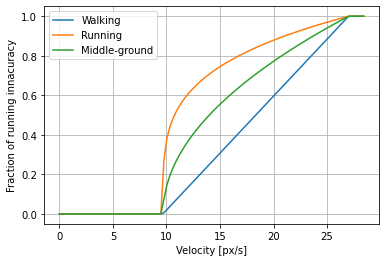

In [25]:
v_max = 28.43
velocities = np.linspace(0., v_max, 100)

plt.plot(velocities, vel_to_fraction(velocities, v_max=v_max, e=1.), label='Walking')
plt.plot(velocities, vel_to_fraction(velocities, v_max=v_max, e=0.25), label='Running')
plt.plot(velocities, vel_to_fraction(velocities, v_max=v_max, e=0.5), label='Middle-ground')

plt.xlabel('Velocity [px/s]')
plt.ylabel('Fraction of running innacuracy')
plt.grid()
plt.legend();

### Tick-independent decay

In [26]:
def tid_fn(rt=0.5, ticks=64, norm=False):
    dt64 = 1. / (64. - 1.)
    dt = 1. / (ticks - 1.)

    t = 0.
    val = 1.

    times = []
    vals = []

    while t < rt / 2.:
        val *= np.exp(-t * dt/dt64 / (np.log10(np.e) * rt)) if norm else np.exp(-t / (np.log10(np.e) * rt))
        times.append(t)
        vals.append(val)
        
        t += dt

    return times, vals

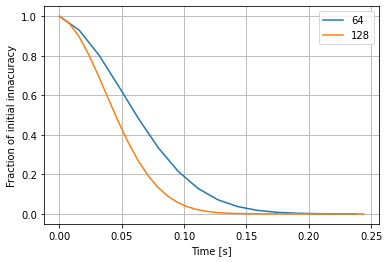

In [27]:
plt.plot(*tid_fn(0.5, 64), label='64')
plt.plot(*tid_fn(0.5, 128), label='128')

plt.xlabel('Time [s]')
plt.ylabel('Fraction of initial innacuracy')
plt.grid()
plt.legend();

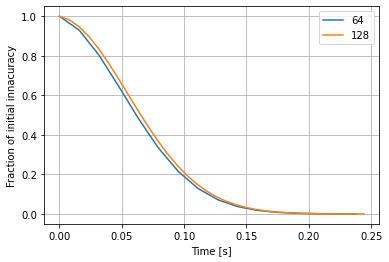

In [28]:
plt.plot(*tid_fn(0.5, 64, norm=True), label='64')
plt.plot(*tid_fn(0.5, 128, norm=True), label='128')

plt.xlabel('Time [s]')
plt.ylabel('Fraction of initial innacuracy')
plt.grid()
plt.legend();

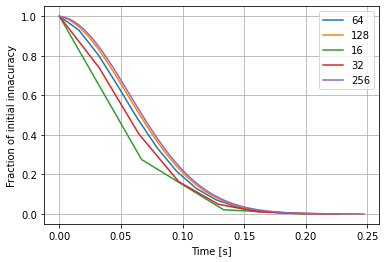

In [29]:
plt.plot(*tid_fn(0.5, 64, norm=True), label='64')
plt.plot(*tid_fn(0.5, 128, norm=True), label='128')
plt.plot(*tid_fn(0.5, 16, norm=True), label='16')
plt.plot(*tid_fn(0.5, 32, norm=True), label='32')
plt.plot(*tid_fn(0.5, 256, norm=True), label='256')

plt.xlabel('Time [s]')
plt.ylabel('Fraction of initial innacuracy')
plt.grid()
plt.legend();

In [30]:
def tid_fn_hold(rt=0.5, inacc=0.1, firing_interval=0.1, ticks=64, norm=False):
    dt64 = 1. / (64. - 1.)
    dt = 1. / (ticks - 1.)

    t = 0.
    val = 0.

    t_wait = 0.
    times = []
    vals = []
    
    while t < 2.*rt:
        val *= np.exp(-t_wait * dt/dt64 / (np.log10(np.e) * rt)) if norm else np.exp(-t_wait / (np.log10(np.e) * rt))

        if t_wait >= firing_interval:
            val += inacc*0.1**(t_wait / rt)
            t_wait = 0.

        times.append(t)
        vals.append(val)

        t_wait += dt
        t += dt

    return times, vals

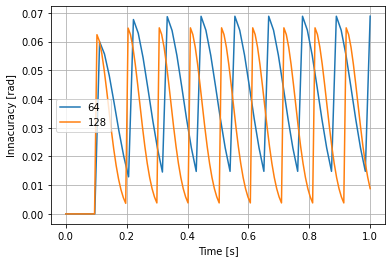

In [31]:
plt.plot(*tid_fn_hold(0.5, 0.1, 0.1, 64), label='64')
plt.plot(*tid_fn_hold(0.5, 0.1, 0.1, 128), label='128')

plt.xlabel('Time [s]')
plt.ylabel('Innacuracy [rad]')
plt.grid()
plt.legend();

Note: If unnormalised, more ticks lead to much faster decay. 

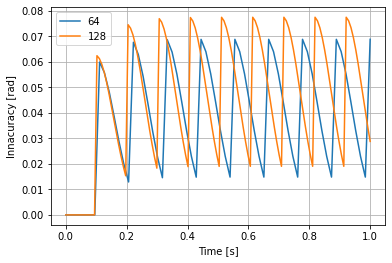

In [32]:
plt.plot(*tid_fn_hold(0.5, 0.1, 0.1, 64, norm=True), label='64')
plt.plot(*tid_fn_hold(0.5, 0.1, 0.1, 128, norm=True), label='128')

plt.xlabel('Time [s]')
plt.ylabel('Innacuracy [rad]')
plt.grid()
plt.legend();

Note: The differences are due to ticks kicking in closer to the actual firing interval, resulting in shorter decay and higher innacuracy gain.

### Recoil

For simplicity, defined as translational and rotational deviation from original position and angle that only affects clientside rendering.

In [33]:
def fire_offset(dmg, apen):
    return 0.5 * dmg/100. + 0.5 * apen

def throw_or_knife_offset(offset=0.5):
    return offset

def aim_punch_offset(pos, pos_src, eff_dmg):
    dp = pos - pos_src
    return dp / np.linalg.norm(dp) * eff_dmg / 10.

def recoil_decay(offset, recovery_time, ticks=64., t_max=1.):
    dt = 1. / (ticks - 1.)
    n = int(t_max/dt)

    times = [i*dt for i in range(n)]
    offsets = []

    for t in times:
        offset *= np.exp(-(t / (np.log10(np.e)*recovery_time)))
        offsets.append(offset)
    
    offsets = np.array(offsets)
    
    return times, offsets

#### Firing

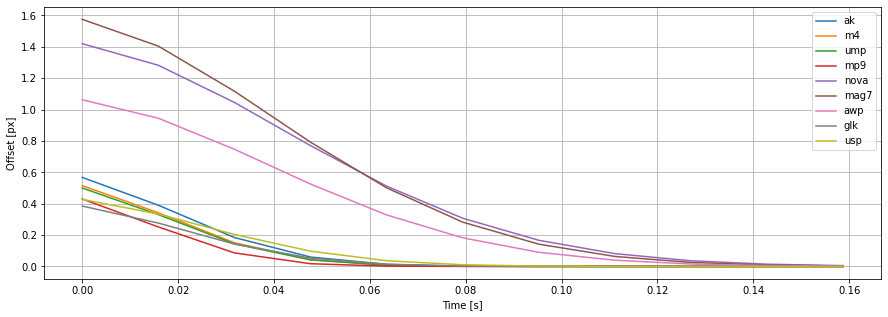

In [34]:
plt.figure(figsize=(15, 5))
t_max = 0.175

for dmg, apen, recovery_time, firing_interval, label in zip(
    [36, 33, 35, 26, 9*26, 8*30, 115, 30., 35.],
    [0.775, 0.7, 0.65, 0.6, 0.5, 0.75, 0.975, 0.47, 0.505],
    [0.37, 0.43, 0.35, 0.26, 0.46, 0.4, 0.35, 0.2, 0.35],
    [0.1, 0.09, 0.09, 0.07, 0.88, 0.85, 1.46, 0.15, 0.17],
    ['ak', 'm4', 'ump', 'mp9', 'nova', 'mag7', 'awp', 'glk', 'usp']
):
    compensated_recovery_time = (1. - np.exp(-recovery_time/firing_interval)) * firing_interval
    single_shot_offset = fire_offset(dmg, apen)

    plt.plot(*recoil_decay(single_shot_offset, compensated_recovery_time, t_max=t_max), label=label)

plt.xlabel('Time [s]')
plt.ylabel('Offset [px]')
plt.grid()
plt.legend();

#### Aim punch

Note: Figures with assumption that all shotgun pellets hit the target and that recoil is shown despite fatality.

In [35]:
# NOTE: Damage falls off based on distance with a reference of 500 units.
units_to_px(500)

56.857036790996666

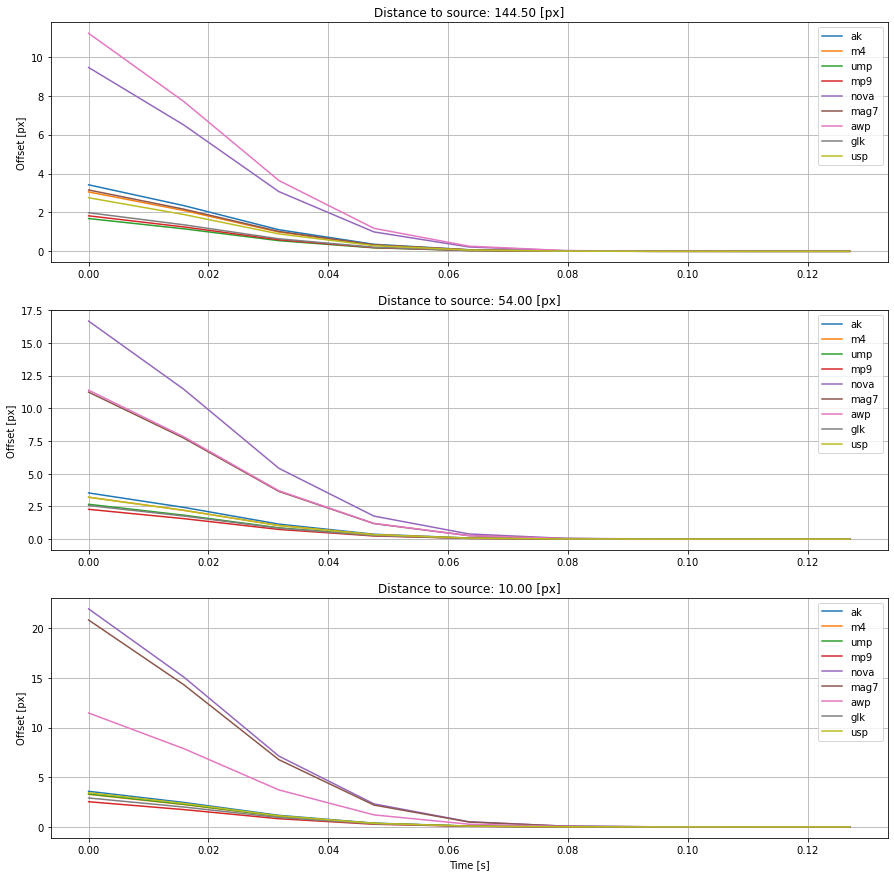

In [36]:
_, axes = plt.subplots(3, 1, figsize=(15, 15))

pos = np.array([0., 0.])
recovery_time = 0.37
firing_interval = 0.1
t_max = 0.15
compensated_recovery_time = (1. - np.exp(-recovery_time/firing_interval)) * firing_interval

for pos_src, ax in zip((np.array([96., 108.]), np.array([0., 54.]), np.array([0., 10.])), axes):
    for dmg, distance_modifier, label in zip(
        [36, 33, 35, 26, 9*26, 8*30, 115, 30., 35.],
        [0.98, 0.97, 0.75, 0.87, 0.7, 0.45, 0.99, 0.85, 0.91],
        ['ak', 'm4', 'ump', 'mp9', 'nova', 'mag7', 'awp', 'glk', 'usp']
    ):
        distance = np.linalg.norm(pos - pos_src)
        eff_dmg = dmg * distance_modifier ** (distance /  56.86)
        aim_punch = np.linalg.norm(aim_punch_offset(pos, pos_src, eff_dmg))

        ax.plot(*recoil_decay(aim_punch, compensated_recovery_time, t_max=t_max), label=label)
        ax.set_title('Distance to source: %.2f [px]' % distance)
        ax.set_ylabel('Offset [px]')
        ax.grid()
        ax.legend()

ax.set_xlabel('Time [s]');

#### Angle recoil

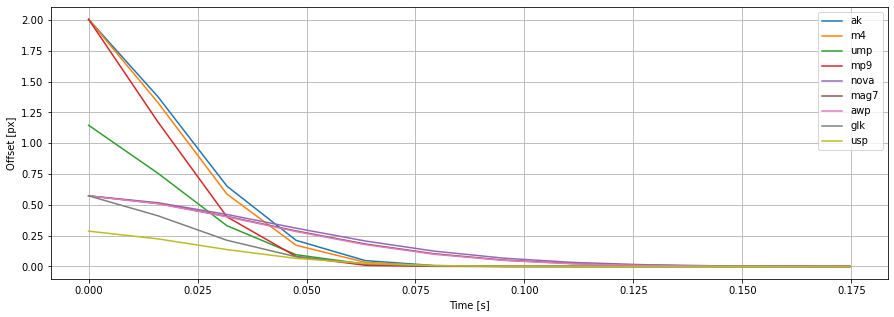

In [37]:
plt.figure(figsize=(15, 5))

t_max = 0.2

for angle_var, recovery_time, firing_interval, label in zip(
    [70, 70, 40, 70, 20, 20, 20, 20, 10],
    [0.37, 0.43, 0.35, 0.26, 0.46, 0.4, 0.35, 0.2, 0.35],
    [0.1, 0.09, 0.09, 0.07, 0.88, 0.85, 1.46, 0.15, 0.17],
    ['ak', 'm4', 'ump', 'mp9', 'nova', 'mag7', 'awp', 'glk', 'usp']
):
    compensated_recovery_time = (1. - np.exp(-recovery_time/firing_interval)) * firing_interval
    angle_offset = angle_var / 1000. / 2. * 180. / np.pi
    plt.plot(*recoil_decay(angle_offset, compensated_recovery_time, t_max=t_max), label=label)

plt.xlabel('Time [s]')
plt.ylabel('Offset [px]')
plt.grid()
plt.legend();

### Movement

`v = v0 + acc*dt`

`acc = (F_internal - F_friction) / mass`

`F_internal = f(vmax)`, e.g. `1*vmax`

`F_friction = g(v)`, e.g. `1*v`

`dt` needs to be capped to handle edge case in reformulation `v = v0 + Dv/Dt*dt`, where `Dv <= vmax` and `dt <= Dt` should hold, otherwise `vmax` can be exceeded.

"Mass" determined experimentally to achieve `vmax` in the targeted window of time.

Reference points based on 'DevinDTV: How It Works: Acceleration and deceleration in CS:GO' | https://www.youtube.com/watch?v=CeVltqiAuc0
- 0 to 50 in 0.032 seconds -> t0 = 0 + 0.032/2, a0 = 50/0.032
- 100 to 150 in 0.063 seconds -> t1 = 0.032 + (0.063+0.032)/2 + 0.063/2, a1 = 50/0.063
- 200 to 250 in 0.266 seconds -> t2 = 0.032 + (0.063+0.032)/2 + 0.063 + (0.266+0.063)/2 + 0.266/2, a2 = 50/0.266

In [38]:
def move_n_steps(dt, n, v_max=28.43, m=1./5.5):
    a = np.zeros(n)
    v = np.zeros(n+1)
    
    for i in range(n):
        a[i] = (v_max - v[i]) / m
        v[i+1] = v[i] + a[i]*min(dt, 0.75*m)
    
    return a, v

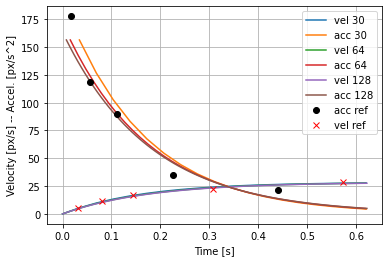

In [39]:
t_max = 0.625

for tick_rate in (30., 64., 128.):
    dt = 1./(tick_rate - 1.)
    n = int(t_max/dt)
    a, v = move_n_steps(dt, n)

    plt.plot([i * dt for i in range(n+1)], v, label='vel %d' % tick_rate)
    plt.plot([i * dt for i in range(1, n+1)], a, label='acc %d' % tick_rate)
    
plt.plot([0.017, 0.056, 0.112, 0.225, 0.441], [177.69, 118.46, 90.25, 34.57, 21.38], 'ko', label='acc ref')
plt.plot([0.032, 0.08, 0.143, 0.3075, 0.5735], [5.69, 11.37, 17.06, 22.74, 28.43], 'rx', label='vel ref')

plt.xlabel('Time [s]')
plt.ylabel('Velocity [px/s] -- Accel. [px/s^2]')
plt.grid()
plt.legend();

In [40]:
v_max = 28.43

for t_max in (0.625, 1.25, 2.5):
    print('%.3f:' % t_max)

    for tick_rate in (30., 64., 128.):
        dt = 1./(tick_rate - 1.)
        n = int(t_max/dt)
        a, v = move_n_steps(dt, n)

        print('%3d | Rel. diff.: %.4f | Abs. diff.: %.4f' % (tick_rate, 1. - v[-1] / v_max, v_max - v[-1]))
        
    print()

0.625:
 30 | Rel. diff.: 0.0227 | Abs. diff.: 0.6454
 64 | Rel. diff.: 0.0284 | Abs. diff.: 0.8064
128 | Rel. diff.: 0.0303 | Abs. diff.: 0.8606

1.250:
 30 | Rel. diff.: 0.0005 | Abs. diff.: 0.0147
 64 | Rel. diff.: 0.0008 | Abs. diff.: 0.0229
128 | Rel. diff.: 0.0009 | Abs. diff.: 0.0261

2.500:
 30 | Rel. diff.: 0.0000 | Abs. diff.: 0.0000
 64 | Rel. diff.: 0.0000 | Abs. diff.: 0.0000
128 | Rel. diff.: 0.0000 | Abs. diff.: 0.0000



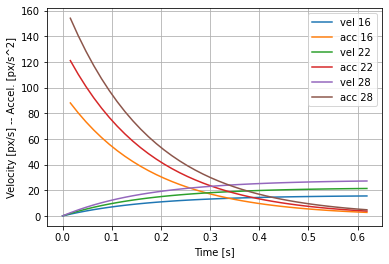

In [41]:
t_max = 0.625
tick_rate = 64.

for v_max in (16., 22., 28.):
    dt = 1./(tick_rate - 1.)
    n = int(t_max/dt)
    a, v = move_n_steps(dt, n, v_max=v_max)

    plt.plot([i * dt for i in range(n+1)], v, label='vel %d' % v_max)
    plt.plot([i * dt for i in range(1, n+1)], a, label='acc %d' % v_max)

plt.xlabel('Time [s]')
plt.ylabel('Velocity [px/s] -- Accel. [px/s^2]')
plt.grid()
plt.legend();

In [42]:
def switch_max_vel(dt, v_max1, v_max2, n1, n2, m=1./5.5):
    a = np.zeros(n1+n2)
    v = np.zeros(n1+n2+1)
    
    for i in range(n1):
        a[i] = (v_max1 - v[i]) / m
        v[i+1] = v[i] + a[i]*dt
    
    for i in range(n1, n1+n2):
        a[i] = (v_max2 - v[i]) / m
        v[i+1] = v[i] + a[i]*dt
    
    return a, v

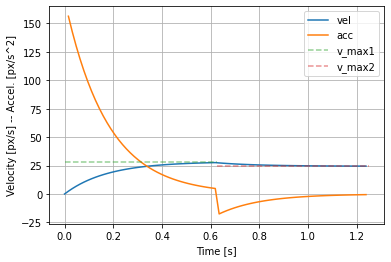

In [43]:
dt = 1./(64. - 1.)
v_max1 = 28.43
v_max2 = 24.44
t_max = 0.625
n1 = int(t_max/dt)
n2 = n1

a, v = switch_max_vel(dt, v_max1, v_max2, n1, n2)

plt.plot([i * dt for i in range(n1+n2+1)], v, label='vel')
plt.plot([i * dt for i in range(1,n1+n2+1)], a, label='acc')
plt.plot([0, t_max], [v_max1, v_max1], '--', alpha=0.5, label='v_max1')
plt.plot([t_max, 2*t_max], [v_max2, v_max2], '--', alpha=0.5, label='v_max2')

plt.xlabel('Time [s]')
plt.ylabel('Velocity [px/s] -- Accel. [px/s^2]')
plt.grid()
plt.legend();

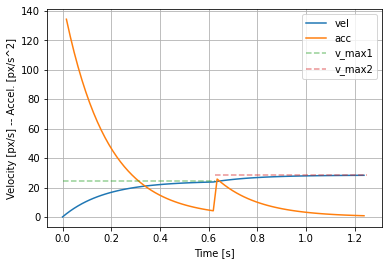

In [44]:
dt = 1./(64. - 1)
v_max1 = 24.44
v_max2 = 28.43
t_max = 0.625
n1 = int(t_max/dt)
n2 = n1

a, v = switch_max_vel(dt, v_max1, v_max2, n1, n2)

plt.plot([i * dt for i in range(n1+n2+1)], v, label='vel')
plt.plot([i * dt for i in range(1,n1+n2+1)], a, label='acc')
plt.plot([0, t_max], [v_max1, v_max1], '--', alpha=0.5, label='v_max1')
plt.plot([t_max, 2*t_max], [v_max2, v_max2], '--', alpha=0.5, label='v_max2')

plt.xlabel('Time [s]')
plt.ylabel('Velocity [px/s] -- Accel. [px/s^2]')
plt.grid()
plt.legend();

In [45]:
def stop_to_halt(v0, dt, n, m=1./5.5):
    a = np.zeros(n)
    v = np.zeros(n+1)
    v[0] = v0
    v_max = 0.

    for i in range(n):
        a[i] = (v_max - v[i]) / m
        v[i+1] = v[i] + a[i]*dt
    
    return a, v

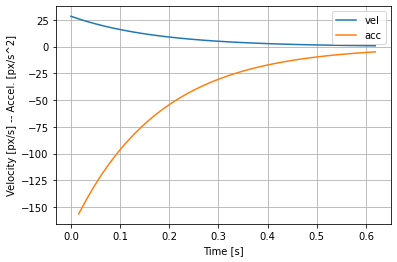

In [46]:
dt = 1./(64. - 1.)
v0 = 28.43
t_max = 0.625
n = int(t_max/dt)

a, v = stop_to_halt(v0, dt, n)

plt.plot([i * dt for i in range(n+1)], v, label='vel')
plt.plot([i * dt for i in range(1,n+1)], a, label='acc')

plt.xlabel('Time [s]')
plt.ylabel('Velocity [px/s] -- Accel. [px/s^2]')
plt.grid()
plt.legend();

In [47]:
v_max = 28.43
tick_rate = 64.

for t_max in (0.625, 1.25, 2.5):
    dt = 1./(tick_rate - 1.)
    n = int(t_max/dt)
    a, v = stop_to_halt(v_max, dt, n)

    print('Rel. val.: %.4f | Abs. val.: %.4f' % (v[-1] / v_max, v[-1]))

Rel. val.: 0.0284 | Abs. val.: 0.8064
Rel. val.: 0.0008 | Abs. val.: 0.0229
Rel. val.: 0.0000 | Abs. val.: 0.0000
